### 载入所需package


### 载入数据

1. 指定数据目录位置
2. 运用pd.read_excel()方程读取数据，若数据格式为csv或者dta，可分别采用pd.read_csv()以及pd.read_stata()

载入数据之后可输入数据变量名查看数据，或使用以下方法查看数据基本情况
1. dataframe.shape: 查看数据维度
2. dataframe.columns: 查看列名
3. dataframe.count(): 查看数据各列的缺失情况

### 数据探索

1. 特征基本信息
    - 平均值
    - 方差
    - 缺失值
2. 数据分布可视化
    - 直方图
    - 箱线图

### 数据清理

1. 删除缺失值 dataframe.dropna()
2. 或者缺失值填补

### 模型建立

1. 训练集测试集划分 train_test_split 
2. 逻辑回归模型建立
    - 模型建立
    - 挑选cutoff值（阈值）
    - 模型相关参数展示

### 模型评估

1. 混淆矩阵（准确性）
2. 绘制ROC曲线以及 AUC值计算
3. 灵敏度 特异度计算

### 模型部署：列线图nomogram

In [1]:
### 载入所需package

from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.model_selection import train_test_split

In [2]:
### load data

path = "data.xlsx"
picu_data = pd.read_excel(path)
picu_data

,age_month,lab_5237_min,lab_5227_min,lab_5225_range,lab_5235_max,lab_5257_min,HOSPITAL_EXPIRE_FLAG
0,4,NaN,NaN,NaN,NaN,NaN,0
1,86,NaN,NaN,NaN,NaN,NaN,1
2,34,NaN,NaN,NaN,NaN,NaN,0
3,94,NaN,NaN,NaN,NaN,NaN,1
4,11,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...
13253,8,NaN,NaN,NaN,NaN,NaN,0
13254,98,7.183,2.1,14.3,47.7,84.0,0
13255,16,6.990,2.8,1.4,53.6,133.0,0
13256,3,NaN,NaN,NaN,NaN,NaN,0


In [3]:
### 查看数据维度
picu_data.shape

(13258, 7)

In [4]:
### 查看列名
picu_data.columns

Index(['age_month', 'lab_5237_min', 'lab_5227_min', 'lab_5225_range',
       'lab_5235_max', 'lab_5257_min', 'HOSPITAL_EXPIRE_FLAG'],
      dtype='object')

In [5]:
### 数据探索

### 数据基本特征
# 平均值
mean = picu_data.mean(axis=0)
print(mean)

age_month               29.989214
lab_5237_min             7.346784
lab_5227_min             2.248062
lab_5225_range           3.841946
lab_5235_max            42.609918
lab_5257_min            91.546444
HOSPITAL_EXPIRE_FLAG     0.058832
dtype: float64


In [6]:
# 中位数
median = picu_data.median(axis=0)
print(median)

age_month                 8.000
lab_5237_min              7.368
lab_5227_min              1.800
lab_5225_range            1.500
lab_5235_max             39.600
lab_5257_min            105.000
HOSPITAL_EXPIRE_FLAG      0.000
dtype: float64


In [7]:
# 方差
var = picu_data.var(axis=0)
print(var)

age_month               1939.011198
lab_5237_min               0.013437
lab_5227_min               3.326965
lab_5225_range            29.846276
lab_5235_max             218.750490
lab_5257_min            3052.254828
HOSPITAL_EXPIRE_FLAG       0.055375
dtype: float64


In [8]:
# 缺失值
missing = picu_data.count()
print(missing)

age_month               13258
lab_5237_min             8668
lab_5227_min             8616
lab_5225_range           8666
lab_5235_max             8671
lab_5257_min             8662
HOSPITAL_EXPIRE_FLAG    13258
dtype: int64


In [9]:
# 查看分类结局分布情况
Counter(picu_data["HOSPITAL_EXPIRE_FLAG"])

Counter({0: 12478, 1: 780})

In [10]:
### 数据清理

### 删除含有空值的行 
# dataframe.dropna()
picu_data_without_na = picu_data.dropna(how="any")
picu_data_without_na

,age_month,lab_5237_min,lab_5227_min,lab_5225_range,lab_5235_max,lab_5257_min,HOSPITAL_EXPIRE_FLAG
624,58,7.427,0.9,0.0,39.9,6.8,0
625,13,7.502,3.3,1.1,27.7,9.3,0
626,3,7.417,0.8,0.0,38.4,7.9,0
627,136,7.349,0.5,1.3,32.4,6.6,0
628,2,7.312,3.9,2.3,40.2,9.0,1
...,...,...,...,...,...,...,...
13249,10,7.345,1.1,12.1,41.9,49.0,0
13250,46,7.342,2.3,5.4,49.1,104.0,0
13254,98,7.183,2.1,14.3,47.7,84.0,0
13255,16,6.990,2.8,1.4,53.6,133.0,0


In [11]:
### 或者采用缺失值填补

# 中位数填补
picu_data_with_median = picu_data.fillna(picu_data.median())
picu_data_with_median

,age_month,lab_5237_min,lab_5227_min,lab_5225_range,lab_5235_max,lab_5257_min,HOSPITAL_EXPIRE_FLAG
0,4,7.368,1.8,1.5,39.6,105.0,0
1,86,7.368,1.8,1.5,39.6,105.0,1
2,34,7.368,1.8,1.5,39.6,105.0,0
3,94,7.368,1.8,1.5,39.6,105.0,1
4,11,7.368,1.8,1.5,39.6,105.0,1
...,...,...,...,...,...,...,...
13253,8,7.368,1.8,1.5,39.6,105.0,0
13254,98,7.183,2.1,14.3,47.7,84.0,0
13255,16,6.990,2.8,1.4,53.6,133.0,0
13256,3,7.368,1.8,1.5,39.6,105.0,0


In [12]:
### 模型建立（以中位数填补后的数据集为例）

## 训练集测试集划分

# 选择自变量X 和 因变量y
X = picu_data_with_median.iloc[:, 0:-1] # 选择第一列与倒数第二列之间的列作为自变量 X
y = picu_data_with_median.iloc[:, -1] # 选择最后一列作为因变量 y

# 训练集测试集划分 以7:3比例划分较为常见 也可使用8:2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0) # 固定random_state使分解可复现

# 查看训练集测试集数据情况
print("训练集数据维度：", end=" ")
print(X_train.shape)
print("测试集数据维度：", end=" ")
print(X_test.shape)

训练集数据维度： (9280, 6)
测试集数据维度： (3978, 6)


In [13]:
## 逻辑回归模型建立

lr_model = LogisticRegression(max_iter=100)
lr_model.fit(X_train, y_train)

# 寻找最优cutoff值
# gt: 训练集中的实际因变量
# pred_prob: 模型预测的概率值
def optimal_cutoff(gt, pred_prob):
    fpr, tpr, threshold = roc_curve(gt, pred_prob)
    gmeans = np.sqrt(tpr*(1-fpr)) ### 指标可以改变，在这里采用使得gmeans最大的值
    ix = np.argmax(gmeans)
    return threshold[ix]

cutoff = optimal_cutoff(y_train, lr_model.predict_proba(X_train)[:,1])

# 模型相关参数展示
print("Coefficient: ", end="")
print(lr_model.coef_[0])

print("Intercept: ", end="")
print(lr_model.intercept_[0])

print("模型阈值: ", end="")
print(cutoff)

Coefficient: [ 2.77517561e-05 -3.97628690e-01  9.14837273e-02  4.78354131e-02
  1.63034464e-02 -1.07085438e-02]
Intercept: -0.05122975766881257
模型阈值: 0.05557708021119314


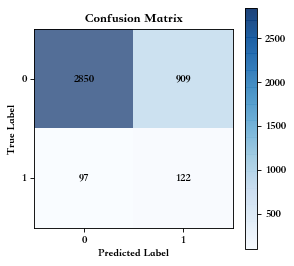

In [14]:
### 模型评估（在测试集测试）

## 混淆矩阵绘制

plt.rcParams["font.sans-serif"]=["Songti Sc"]
plt.rcParams["axes.unicode_minus"]=False

# X,y分别为所需绘制混淆矩阵的数据自变量 因变量
# model为所建立的模型
# thre为模型的阈值 默认为0.5
def confusion_matrix_plot(X, y, model, title="Confusion Matrix", thre=0.5, normalize=None):
    gt = np.array(y, dtype=int)
    pred_prob = model.predict_proba(X)[:,1]
    pred = (pred_prob > thre)+0
    pred = np.array(pred, dtype=int)
    cm = confusion_matrix(gt, pred, normalize=normalize)

    fig = plt.figure(figsize=(4,4), dpi=80)
    plt.imshow(cm, cmap='Blues', alpha=0.7)
    plt.colorbar()
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks([0,1],[0, 1])
    plt.yticks([0,1],[0, 1])
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if normalize == None:
                text = plt.text(j, i, '{:d}'.format(cm[i, j]), ha="center", va="center", color="k")
            else:
                text = plt.text(j, i, '{:.4f}'.format(cm[i, j]), ha="center", va="center", color="k")
    return fig

confusion = confusion_matrix_plot(X=X_test, y=y_test, model=lr_model, thre=cutoff)

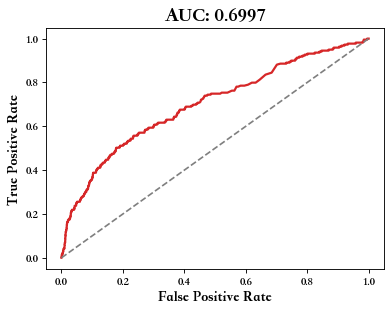

In [15]:
## 绘制ROC曲线

def roc_auc_plot(X, y, model, thre=0.5):
    gt = y
    pred_prob = model.predict_proba(X)[:,1]

    fig = plt.figure(figsize=(5,4),dpi=80)
    fpr, tpr, _ = roc_curve(gt, pred_prob)
    roc_score = roc_auc_score(gt, pred_prob)
    plt.plot(fpr, tpr, color='tab:red', lw=2)
    plt.plot([0,1],[0,1], color='tab:gray', linestyle='--')
    plt.xlabel('False Positive Rate', fontsize=13)
    plt.ylabel('True Positive Rate', fontsize=13)
    plt.title('AUC: {:.4f}'.format(roc_score), fontsize=18)
    plt.tight_layout()

    return fig

roc = roc_auc_plot(X=X_test, y=y_test, model=lr_model, thre=cutoff)

In [16]:
## 灵敏度 特异度计算

# 计算列联表
tn, fp, fn, tp = confusion_matrix(y_test, lr_model.predict_proba(X_test)[:,1]>cutoff).ravel()

# 灵敏度
sensitivity = tp/(tp+fn)
# 特异度
specificity = tn/(tn+fp)

print("灵敏度: ", end="")
print(sensitivity)
print("特异度: ", end="")
print(specificity)

灵敏度: 0.5570776255707762
特异度: 0.7581803671189146


# 在线列线图生成工具： http://183.162.233.24:10081/Nomogram/v3 